
# SCM-01 — Forecasting & Inventory Policies

**Decision Intelligence flow:** Forecast → Policy → Simulation → Decision

*Portfolio: Core → Supply_Chain_Logistics*



In [4]:
from src.bootstrap import init_project
env = init_project()

# Optional: unpack if you prefer direct names
PROJECT_ROOT  = env["PROJECT_ROOT"]
RAW_DIR       = env["RAW_DIR"]
INTERIM_DIR   = env["INTERIM_DIR"]
PROCESSED_DIR = env["PROCESSED_DIR"]
FIG_DIR       = env["FIG_DIR"]
CONFIG        = env["CONFIG"]
SEED          = env["SEED"]


Project Root: c:\Users\beall\OneDrive\Documents\Portfolio\Core\Supply_Chain_Logistics\SCM-01_forecasting_inventory_policies
Data        : c:\Users\beall\OneDrive\Documents\Portfolio\Core\Supply_Chain_Logistics\SCM-01_forecasting_inventory_policies\data
Figures     : c:\Users\beall\OneDrive\Documents\Portfolio\Core\Supply_Chain_Logistics\SCM-01_forecasting_inventory_policies\reports\figures
Config      : config.yaml


In [3]:

# --- Imports ---
import os, math, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass

# Optional libraries (install in your environment): statsmodels, pmdarima, simpy, networkx, shap
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# import pmdarima as pm
# import simpy
# import networkx as nx
# import shap

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10, 5)

# Ensure folders exist (no-ops if already there)
for p in [DATA_DIR, RAW_DIR, INTERIM_DIR, PROCESSED_DIR, "reports", FIG_DIR, "src"]:
    Path(p).mkdir(parents=True, exist_ok=True)
print("Folders ready.")


Folders ready.



## 1. Data — acquire or generate
- Option A: Place a public retail demand file in `data/raw/` with columns like `date, demand_qty, promo_flag`.
- Option B (below): Generate synthetic weekly demand with seasonality & promos.


In [13]:

def generate_synthetic_weekly(n_weeks=156, level=200, trend=0.2, season_amp=30, promo_uplift=0.35, promo_freq=0.1, noise_sd=20, seed=SEED):
    rng = np.random.default_rng(seed)
    t = np.arange(n_weeks)
    seasonal = season_amp * np.sin(2 * np.pi * t / 52)
    promos = (rng.random(n_weeks) < promo_freq).astype(int)
    demand = level + trend * t + seasonal + promos * promo_uplift * (level + seasonal)
    demand = np.maximum(0, rng.normal(demand, noise_sd))
    df = pd.DataFrame({
        "date": pd.date_range("2020-01-05", periods=n_weeks, freq="W-SUN"),
        "sku_id": CONFIG["sku_id"],
        "demand_qty": demand.round().astype(int),
        "promo_flag": promos
    })
    return df

# Generate & save synthetic baseline
df_raw = generate_synthetic_weekly()
df_raw.to_csv(f"{RAW_DIR}/synthetic_weekly_demand.csv", index=False)
df_raw.head()


,date,sku_id,demand_qty,promo_flag
0,2020-01-05,SKU-001,199,0
1,2020-01-12,SKU-001,239,0
2,2020-01-19,SKU-001,210,0
3,2020-01-26,SKU-001,231,0
4,2020-02-02,SKU-001,280,1


In [14]:
print(RAW_DIR)

data/raw


In [12]:
from pathlib import Path
path = Path(RAW_DIR)
print("Exists?", path.exists())
print("Absolute:", path.resolve())
print("Contents:", list(path.glob("*")))


Exists? True
Absolute: C:\Users\beall\OneDrive\Documents\Portfolio\Core\Supply_Chain_Logistics\SCM-01_forecasting_inventory_policies\notebooks\data\raw
Contents: [WindowsPath('data/raw/synthetic_weekly_demand.csv')]



## 2. EDA & sanity checks
- Trend/seasonality plots
- Intermittency checks (share of zero-demand periods)
- Basic stats


,date,sku_id,demand_qty,promo_flag
count,156,156,156.000000,156.000000
unique,NaN,1,NaN,NaN
top,NaN,SKU-001,NaN,NaN
freq,NaN,156,NaN,NaN
mean,2021-06-30 12:00:00,NaN,222.391026,0.096154
min,2020-01-05 00:00:00,NaN,154.000000,0.000000
25%,2020-10-02 06:00:00,NaN,198.750000,0.000000
50%,2021-06-30 12:00:00,NaN,219.500000,0.000000
75%,2022-03-28 18:00:00,NaN,246.000000,0.000000
max,2022-12-25 00:00:00,NaN,345.000000,1.000000


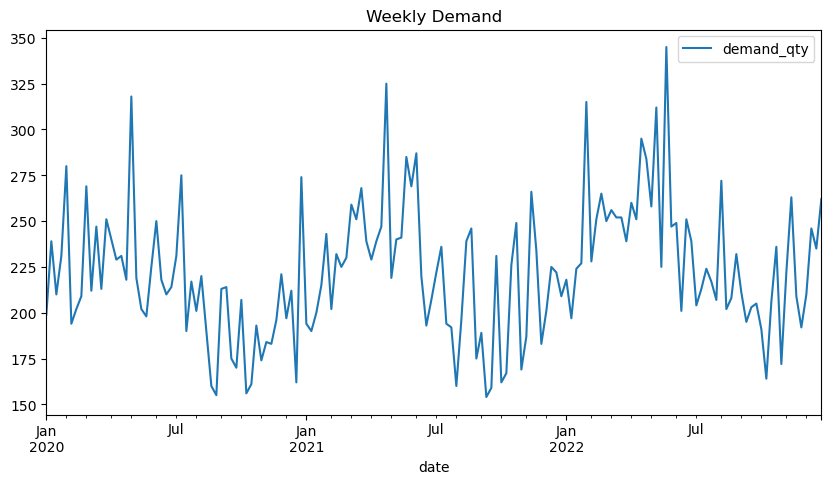

Zero-demand share: 0.00%


In [5]:

df = pd.read_csv(f"{RAW_DIR}/synthetic_weekly_demand.csv", parse_dates=["date"])
display(df.describe(include="all"))
df.plot(x="date", y="demand_qty", title="Weekly Demand"); plt.show()
zero_share = (df["demand_qty"]==0).mean()
print(f"Zero-demand share: {zero_share:.2%}")



## 3. Forecasting
Start with explainable baselines and escalate to ETS/ARIMA as needed. Use rolling-origin cross-validation.
**Metrics:** MAE, RMSE, sMAPE, MASE; also check prediction interval coverage.


In [6]:

from typing import Tuple

def split_train_test(df, cutoff_date):
    train = df[df["date"] <= cutoff_date].copy()
    test = df[df["date"] >  cutoff_date].copy()
    return train, test

def naive_forecast(train: pd.Series, horizon: int) -> np.ndarray:
    return np.repeat(train.iloc[-1], horizon)

def seasonal_naive_forecast(train: pd.Series, horizon: int, season=52) -> np.ndarray:
    history = train.values
    fc = []
    for h in range(1, horizon+1):
        fc.append(history[-season + (h-1) % season])
    return np.array(fc)

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    smape = 100 * np.mean(2*np.abs(y_true - y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-9))
    mase = mae / (np.mean(np.abs(np.diff(y_true))) + 1e-9)
    return {"MAE": mae, "RMSE": rmse, "sMAPE%": smape, "MASE": mase}

# Example rolling-origin evaluation with naive & seasonal naive
series = df.set_index("date")["demand_qty"].asfreq("W-SUN").fillna(method="ffill")
cutoff = series.index[-26]  # last half-year as test
train, test = split_train_test(series.reset_index().rename(columns={"index":"date","demand_qty":"y"}), cutoff)

y_train = series[series.index <= cutoff]
y_test = series[series.index  > cutoff]

fc_naive = naive_forecast(y_train, len(y_test))
fc_snaive = seasonal_naive_forecast(y_train, len(y_test), season=52)

print("Naive:", metrics(y_test.values, fc_naive))
print("Seasonal Naive:", metrics(y_test.values, fc_snaive))


Naive: {'MAE': np.float64(20.6), 'RMSE': np.float64(28.38238890579861), 'sMAPE%': np.float64(9.526021340820002), 'MASE': np.float64(0.7368107302269994)}
Seasonal Naive: {'MAE': np.float64(28.08), 'RMSE': np.float64(33.31426121047861), 'sMAPE%': np.float64(13.505096914935233), 'MASE': np.float64(1.0043517138239875)}



## 4. Inventory Policy Design
- EOQ benchmark
- Continuous-review (Q, R) with safety stock from lead-time demand variability
- Periodic-review (s, S) (optional)


In [7]:

def eoq(D, S, H):
    return math.sqrt((2*D*S)/H)

def normal_safety_stock(z, sigma_LT):
    return z * sigma_LT

def reorder_point(mu_LT, z, sigma_LT):
    return mu_LT + z * sigma_LT

# Example: translate weekly demand forecast to annual parameters for EOQ
annual_demand = series[-52:].sum()  # crude: last year
H = CONFIG["holding_cost_rate"] * CONFIG["unit_cost"]
Q_star = eoq(D=annual_demand, S=CONFIG["order_cost"], H=H)
print(f"EOQ (units): {Q_star:.1f}")

# Lead-time demand approximation (assuming weekly demand variance and LT in weeks)
weekly_mu = series[-52:].mean()
weekly_sigma = series[-52:].std(ddof=1)
LT_weeks = max(1, int(round(CONFIG['lead_time_days']/7)))
mu_LT = weekly_mu * LT_weeks
sigma_LT = math.sqrt(LT_weeks) * weekly_sigma  # assumes independent weeks
z = 1.645  # ~95% cycle service level
ss = normal_safety_stock(z, sigma_LT)
R = reorder_point(mu_LT, z, sigma_LT)
print(f"Safety stock: {ss:.1f}, Reorder point R: {R:.1f}")


EOQ (units): 1209.6
Safety stock: 82.9, Reorder point R: 551.8



## 5. Simulation (stochastic validation)
Simulate the (Q, R) policy with stochastic demand & lead time to estimate service and cost distributions.


{'fill_rate': np.float64(0.9989666338555708), 'total_cost': np.float64(3619.4506926048653), 'order': 1500.0, 'holding': np.float64(1993.4626922760785), 'stockout': np.float64(125.98800032878671)}


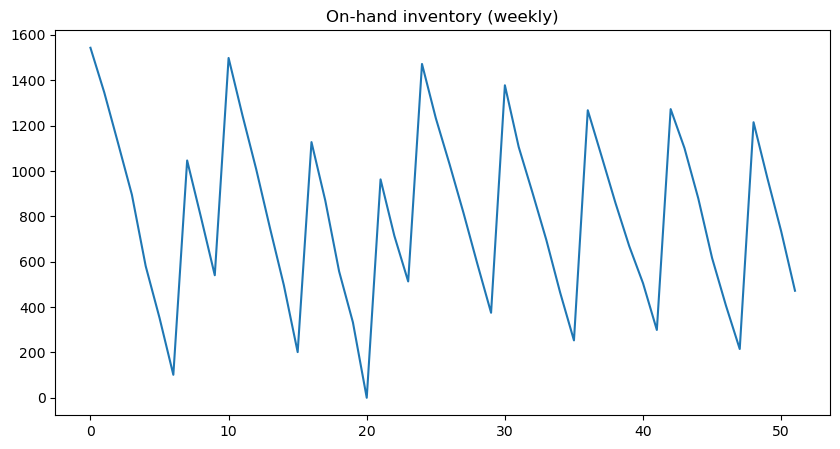

In [8]:

# Minimal period-advance simulation (no external libs)
import random

def simulate_qr(
    demand_series, Q, R, unit_cost, order_cost, holding_cost_rate, lead_time_weeks=2, lost_sales=True, seed=SEED
):
    rng = np.random.default_rng(seed)
    on_hand = R + Q  # start with a buffer
    pipeline = []    # list of tuples (arrival_week, qty)
    costs = {"order":0.0, "holding":0.0, "stockout":0.0}
    fulfilled, demanded = 0, 0
    on_hand_history = []

    for t, d in enumerate(demand_series):
        # receive orders that arrive this week
        for arr, qty in list(pipeline):
            if arr == t:
                on_hand += qty
                pipeline.remove((arr, qty))

        demanded += d
        if on_hand >= d:
            on_hand -= d
            fulfilled += d
        else:
            short = d - on_hand
            fulfilled += on_hand
            on_hand = 0
            if lost_sales:
                costs["stockout"] += short * unit_cost  # proxy penalty
            else:
                # backorder model could accrue penalty differently
                costs["stockout"] += short * unit_cost

        # place order if inventory position <= R
        inv_position = on_hand + sum(q for _, q in pipeline)
        if inv_position <= R:
            # stochastic lead time (±1 week jitter)
            lt = max(1, int(round(lead_time_weeks + rng.normal(0, 0.5))))
            pipeline.append((t + lt, int(round(Q))))
            costs["order"] += order_cost

        # holding cost (approx weekly)
        costs["holding"] += (on_hand * unit_cost) * (holding_cost_rate/52.0)
        on_hand_history.append(on_hand)

    fill_rate = fulfilled / max(1, demanded)
    total_cost = sum(costs.values())
    return {"fill_rate": fill_rate, "total_cost": total_cost, **costs, "on_hand_history": on_hand_history}

sim_res = simulate_qr(
    demand_series=series[-52:].values,
    Q=Q_star,
    R=R,
    unit_cost=CONFIG["unit_cost"],
    order_cost=CONFIG["order_cost"],
    holding_cost_rate=CONFIG["holding_cost_rate"],
    lead_time_weeks=max(1, int(round(CONFIG["lead_time_days"]/7)))
)
print({k:v for k,v in sim_res.items() if k!='on_hand_history'})
plt.plot(sim_res["on_hand_history"]); plt.title("On-hand inventory (weekly)"); plt.show()



## 6. Causal graph (reasoning aid)
Sketch a DAG of drivers (price, promo, holidays, supplier reliability) and discuss interventions.


In [9]:

# Placeholder: build a simple DAG with networkx when available
# import networkx as nx
# G = nx.DiGraph()
# G.add_edges_from([("Promo", "Demand"), ("Price","Demand"), ("SupplierReliability","LeadTime"), ("LeadTime","ServiceLevel"), ("Demand","ServiceLevel")])
# nx.draw(G, with_labels=True)
print("DAG placeholder — implement with networkx if desired.")


DAG placeholder — implement with networkx if desired.



## 7. Decision & recommendation
Summarize: chosen policy, expected service/cost, sensitivity to lead time & demand shocks, and risk‑aware rationale.



## Appendix
- Assumptions & parameter derivations
- Reproducibility notes (seed, versions)
